In [2]:
import pandas as pd

### Download data from MTA

In [40]:
url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190601.txt"
df = pd.read_csv(url)

In [3]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,7071830,2396411
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,04:00:00,REGULAR,7071844,2396415
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,08:00:00,REGULAR,7071864,2396443
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,12:00:00,REGULAR,7071943,2396500
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,16:00:00,REGULAR,7072182,2396555


pseudo code
- calculate the number of people entering each station for every timestamp
    - the number of entries is cumulative (when does it reset to 0?)
- calculate the number of people exiting each station for every timestamp

In [41]:
# get rid of extrac strings in columns 
df.columns = df.columns.str.replace(" ", "")

In [32]:
# get absolute values of entries and exits
#df['ENTRIES'] = df['ENTRIES'].abs()
#df['EXITS'] = df['EXITS'].abs()

In [42]:
# Use diff() to derrive the actual number of people from the culmulative value
# for entries and exits for each SCP
df['people_in'] = df.groupby(['STATION', 'UNIT', 'SCP'])['ENTRIES'].transform(lambda x: x.diff().abs())
df['people_out'] = df.groupby(['STATION', 'UNIT', 'SCP'])['EXITS'].transform(lambda x: x.diff().abs())

In [34]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,people_in,people_out
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,7071830,2396411,nan,nan
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,04:00:00,REGULAR,7071844,2396415,14.000,4.000
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,08:00:00,REGULAR,7071864,2396443,20.000,28.000
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,12:00:00,REGULAR,7071943,2396500,79.000,57.000
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,16:00:00,REGULAR,7072182,2396555,239.000,55.000


In [43]:
# check to make sure the calclation was correct
# each scp at time 00:00:00 should be NaN
df[df['people_in'].isna()]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,people_in,people_out
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,7071830,2396411,nan,nan
42,A002,R051,02-00-01,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,6298050,1412557,nan,nan
84,A002,R051,02-03-00,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,1236982,4651756,nan,nan
126,A002,R051,02-03-01,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,1115712,1720977,nan,nan
168,A002,R051,02-03-02,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,6200254,8353543,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
203575,TRAM2,R469,00-00-01,RIT-ROOSEVELT,R,RIT,05/25/2019,01:00:00,REGULAR,3044413,36029,nan,nan
203619,TRAM2,R469,00-03-00,RIT-ROOSEVELT,R,RIT,05/25/2019,01:00:00,REGULAR,669761,26005,nan,nan
203663,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,05/25/2019,01:00:00,REGULAR,3051155,391951,nan,nan
203707,TRAM2,R469,00-05-00,RIT-ROOSEVELT,R,RIT,05/25/2019,01:00:00,REGULAR,2895,62,nan,nan


In [44]:
# Remove na data for now
df = df.dropna()
#DataFrame.dropna(self, axis=0, how='any', thresh=None, subset=None, inplace=False)

In [45]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,people_in,people_out
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,04:00:00,REGULAR,7071844,2396415,14.000,4.000
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,08:00:00,REGULAR,7071864,2396443,20.000,28.000
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,12:00:00,REGULAR,7071943,2396500,79.000,57.000
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,16:00:00,REGULAR,7072182,2396555,239.000,55.000
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,20:00:00,REGULAR,7072456,2396593,274.000,38.000


In [46]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe()

,ENTRIES,EXITS,people_in,people_out
count,198927.000,198927.000,198927.000,198927.000
mean,42255027.697,34442423.498,9569.588,2101.370
std,214275595.638,196509556.296,3753018.199,865850.774
min,0.000,0.000,0.000,0.000
25%,334733.000,138212.000,10.000,8.000
50%,2143919.000,1227057.000,67.000,49.000
75%,6739089.500,4570164.000,217.000,155.000
max,2129288981.000,2124055172.000,1661415925.000,386167799.000


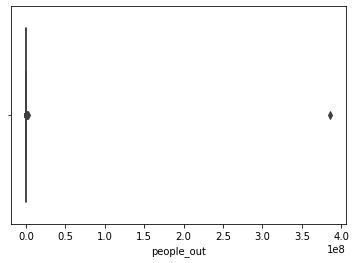

In [49]:
sns.boxplot(x=df["people_out"])

In [ ]:
from scipy import stats
import numpy as np

In [54]:
# Remove outliers
df = df[(np.abs(stats.zscore(df["people_out"])) < 5)]

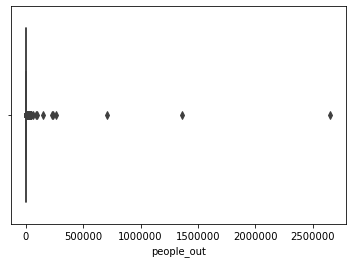

In [55]:
sns.boxplot(x=df["people_out"])

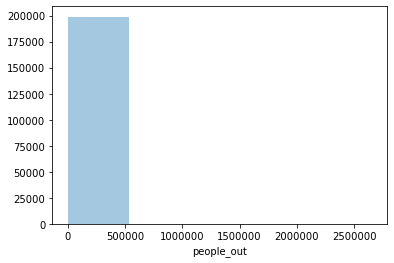

In [64]:
sns.distplot(df["people_out"], bins=5, kde=False, norm_hist=False)

### Make Graphs showing frequency for time of day and day of week 
- for now it will be a random selection of stations but we will choose the stations we want to select  

In [10]:
import seaborn as sns

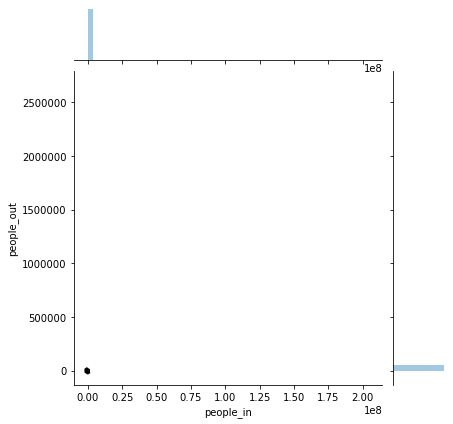

In [65]:
sns.jointplot(x="people_in", y="people_out", data=df, kind="hex")

In [ ]:
sns.lineplot(x="timepoint", y="signal", hue="station",data=df)